In [1]:
%config IPCompleter.greedy=True
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

# Estudio de la respuesta por país al coronavirus

Este notebook analiza la respuesta que ha dado cada país del mundo al coronavirus contrastando el número de casos que se han notificado con la calidad de su sistema de salud. Cada una de estas dos variables se obtiene:

- Casos: obtenido a partir del dataset de origen
- Calidad del sistema de salud: índice diseñado por nosotros que evalúa la capacidad del sistema de salud basándonos en la mortalidad en adultos y en la inversión nacional en salud.

In [2]:
# Cargamos las librerías
from pandas import read_csv
import pandas as pd
import numpy as np
from numpy import unique, where
from matplotlib import pyplot as plt
import seaborn as sb
import requests
from pandas_profiling import ProfileReport
from pathlib import Path
import datetime
import io
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model

url_base_dataset = 'https://raw.githubusercontent.com/samuelojeda082/tecnicasia/main/dataset.csv'
url_aditional_data = 'https://raw.githubusercontent.com/samuelojeda082/tecnicasia/main/data_merged.csv'

## Preparar dataset de origen

Se carga y se limpia el dataset:

- Se eliminan los datos con fechas incorrectas
- Se quitan los valores nulos

Se tomará la variable notification_rate_per_100000_population_14_days

In [3]:
# Cargar fichero con los datos de los casos de covid
r = requests.get(url_base_dataset)
if r.ok:
    data = r.content.decode('utf8')
    df_main_data = pd.read_csv(io.StringIO(data), index_col=0, parse_dates=[0], infer_datetime_format=True, sep=',').reset_index()
else:
    print(r)
df_main_data.head()

,dateRep,year_week,cases_weekly,deaths_weekly,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,notification_rate_per_100000_population_14_days
0,2021-01-02,2021-04,267,16,Afghanistan,AF,AFG,38041757.0,Asia,2.58
1,2021-01-25,2021-03,713,43,Afghanistan,AF,AFG,38041757.0,Asia,3.34
2,2021-01-18,2021-02,557,45,Afghanistan,AF,AFG,38041757.0,Asia,3.24
3,2021-11-01,2021-01,675,71,Afghanistan,AF,AFG,38041757.0,Asia,4.15
4,2021-04-01,2020-53,902,60,Afghanistan,AF,AFG,38041757.0,Asia,7.61


In [4]:
# Quitar los nulos y datos que son sucios
df_main_data = df_main_data[df_main_data['dateRep']<=datetime.datetime.utcnow()]
df_main_data = df_main_data[~df_main_data['countriesAndTerritories'].isnull()]
df_main_data = df_main_data[~df_main_data['countryterritoryCode'].isnull()]

df_main_data  #.loc[df_main_data['countriesAndTerritories']=='Montenegro', ['geoId']]

,dateRep,year_week,cases_weekly,deaths_weekly,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,notification_rate_per_100000_population_14_days
0,2021-01-02,2021-04,267,16,Afghanistan,AF,AFG,38041757.0,Asia,2.58
1,2021-01-25,2021-03,713,43,Afghanistan,AF,AFG,38041757.0,Asia,3.34
2,2021-01-18,2021-02,557,45,Afghanistan,AF,AFG,38041757.0,Asia,3.24
5,2020-12-28,2020-52,1994,88,Afghanistan,AF,AFG,38041757.0,Asia,7.19
6,2020-12-21,2020-51,740,111,Afghanistan,AF,AFG,38041757.0,Asia,6.56
...,...,...,...,...,...,...,...,...,...,...
10428,2020-04-20,2020-16,11,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,0.11
10429,2020-04-13,2020-15,5,2,Zimbabwe,ZW,ZWE,14645473.0,Africa,0.05
10430,2020-06-04,2020-14,2,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,0.05
10431,2020-03-30,2020-13,5,1,Zimbabwe,ZW,ZWE,14645473.0,Africa,0.05


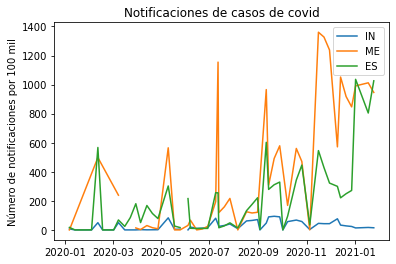

In [5]:
# Representamos los datos de Gibraltar para observar el comportamiento de los mismos.
# Se observa que el número de casos notificados tiene un pico en enero de 2021
mask = (df_main_data['geoId']=='ME') | (df_main_data['geoId']=='ES')| (df_main_data['geoId']=='IN')
df = df_main_data[mask].copy()
df = df.sort_values('dateRep')
for label in list(set(df['geoId'].values.tolist())):
    plt.plot(
        df.loc[df['geoId']==label, ['dateRep']],
        df.loc[df['geoId']==label, ['notification_rate_per_100000_population_14_days']],
        label=label)
plt.title('Notificaciones de casos de covid')
plt.legend()
# plt.xlabel('xAxis name')
plt.ylabel('Número de notificaciones por 100 mil')
plt.show()

## Preparar el dataset adicional

Este dataset se ha calculado a partir de la unión de los dos siguientes:
    
- Gasto en salud respecto al GDP del país (en tanto por ciento)
- Mortalidad en adulto por 1000 personas

Este dataset se tomará como punto de referencia de la capacidad de cada país a afrontar la pandemia ya que se utilizan datos previos al comienzo de esta.

In [6]:
# Cargar el fichero con datos de datasets adicionales
r = requests.get(url_aditional_data)
if r.ok:
    data = r.content.decode('utf8')
    df_additional_data = pd.read_csv(io.StringIO(data), index_col=0, parse_dates=[0], sep=';').reset_index()
else:
    print(r)

In [7]:
df_additional_data

,country,mortality_rate,health_expenditure
0,Afghanistan,245,9.40
1,Albania,96,5.26
2,Algeria,95,6.22
3,Angola,238,2.55
4,Antigua and Barbuda,120,5.23
...,...,...,...
178,Venezuela (Bolivarian Republic of),157,3.56
179,Viet Nam,125,5.92
180,Yemen,221,NaN
181,Zambia,286,4.93


## Preparar datos para su análisis

A continuación:

- Se agrupan por país los datos de los casos de coronavirus notificados para el dataset de origen. La variable a estudiar se resume aplicando la media.
- Se eliminan los datos que queden nulos
- Se une el dataset de origen ya limpio con el dataset adicional a través del nombre de los países y se eliminan aquellos datos que no se han podido unir.
- Calcular el índice de calidad del sistema de salud (health_system_score)

In [8]:
# Agrupamos los casos notificados por país, calculamos su media y limpiamos
df_main_filtered = df_main_data[['countriesAndTerritories', 'notification_rate_per_100000_population_14_days']].groupby(by='countriesAndTerritories').mean().reset_index()
df_main_filtered = df_main_filtered[~df_main_filtered['countriesAndTerritories'].isna()]

In [9]:
# Unimos con los datasets adicionales
df_merge = pd.merge(df_main_filtered, df_additional_data, left_on='countriesAndTerritories', right_on='country', how='outer')

In [10]:
# Borramos los datos que no se han unido correctamente porque faltan en el dataset adicional
mask = (df_merge['countriesAndTerritories'].isna()) | (df_merge['country'].isna())

# with pd.option_context("display.min_rows", 50, "display.max_rows", 300, "display.max_columns", 5):
#     display(df_merge[mask].sort_values('country'))

df_clean = df_merge[~mask].copy()

Preparamos los datos para realizar el clústering sobre dos variables:
    
- Casos: número de casos notificados por 100k habitantes. Se escala para tener valores entre 0 y 1 siendo 1 el máximo de notificados de todos los países estudiados
- Calificación del sistema de salud: Se calcula como (100% - %mortandad) x gasto salud pública. Resultado: un índice que a mayor valor, mejor sistema de salud. Se escala para tener valores entre 0 y 1 siendo 1 el país con mayor inversión en salud si no tuviese mortalidad adulta

In [11]:
df_format = df_clean.copy()

# Escalar el número de casos
max_notifications = df_format['notification_rate_per_100000_population_14_days'].max()
df_format['cases'] = df_format['notification_rate_per_100000_population_14_days']/max_notifications

# Calcular y escalar el índice del sistema de salud
max_health_exp = df_format['health_expenditure'].max()
df_format['health_system_score'] = (1 - df_format['mortality_rate']/1000) * df_format['health_expenditure']/max_health_exp

# Dar formato al dataframe y limpiar
df_format = df_format[['country', 'cases', 'health_system_score']]
df_format = df_format[~df_format['health_system_score'].isna()]

print('Países ordenados por índice de inversión descendiente')
display(df_format.sort_values('health_system_score', ascending=False))

print('Países ordenados por número de casos descendiente')
display(df_format.sort_values('cases', ascending=False))

Países ordenados por índice de inversión descendiente


,country,cases,health_system_score
186,Switzerland,0.500284,0.951000
74,Germany,0.209716,0.895735
69,France,0.396723,0.880517
100,Japan,0.022875,0.874710
185,Sweden,0.431126,0.869798
...,...,...,...
15,Bangladesh,0.034741,0.171364
4,Angola,0.006690,0.163561
20,Benin,0.003556,0.158874
54,Djibouti,0.068794,0.147441


Países ordenados por número de casos descendiente


,country,cases,health_system_score
131,Montenegro,1.000000,0.638588
175,Slovenia,0.734740,0.648350
150,Panama,0.719122,0.544026
116,Luxembourg,0.706396,0.420350
51,Czechia,0.703099,0.591780
...,...,...,...
32,Burundi,0.001471,0.462576
41,China,0.000623,0.414310
67,Fiji,0.000621,0.234333
33,Cambodia,0.000244,0.421288


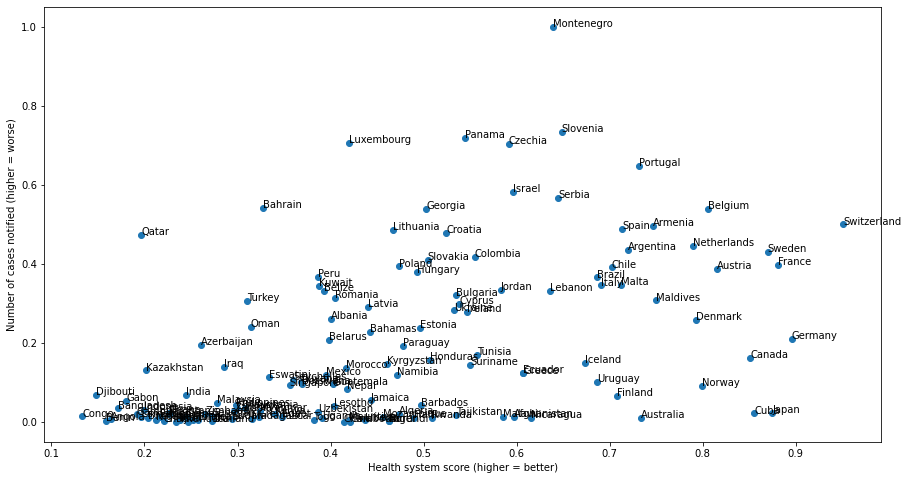

In [33]:
# Representar los datos para ver si tienen sentido.
# Vemos los paises europeos hacia la derecha (buen sistema de salud) y algunos como españa con valores altos (eje Y) lo que indican que tienen muchos casos.
# Tareas pendientes, revisar si el valor tomado para el eje Y es relevante o cambiar por otro (España está muy bajo)
plt.figure(figsize=(15,8))
plt.scatter(df_format['health_system_score'], df_format['cases'])

for i, txt in enumerate(df_format['country'].tolist()):
    plt.annotate(str(txt), (df_format['health_system_score'].iloc[i], df_format['cases'].iloc[i])) 
    
# plt.yticks(range(0,1,1))
# plt.xticks(range(0, 1, 1))
plt.xlabel('Health system score (higher = better)')
plt.ylabel('Number of cases notified (higher = worse)')
plt.show()

In [13]:
df_study = df_format.copy()
df_study.head()

,country,cases,health_system_score
0,Afghanistan,0.012610,0.597391
1,Albania,0.260997,0.400256
2,Algeria,0.021567,0.473830
4,Angola,0.006690,0.163561
7,Argentina,0.435486,0.719880


Veamos que distribución toman las variables. Como dato curioso vemos que la variable `health_system_score` está distribuida como una normal. Esto será ideal para el modelo Gaussian Mixtures.

<Figure size 432x288 with 0 Axes>

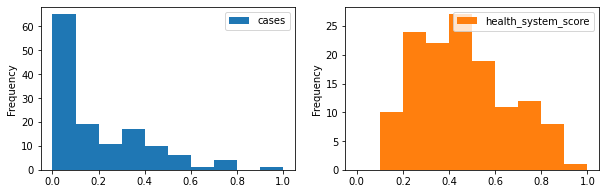

In [15]:
plt.figure()
df_study.plot(kind = "hist", subplots = True, sharex = False, sharey = False,figsize=(10,3), layout = (1,2) )
plt.show()

Vamos a obtener un informe exhaustivo de los datos del datset con el que trabajaremos. 

In [16]:
profile = ProfileReport(df_study, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Análisis de modelos de clústering

In [17]:
paises_test = df_study["country"].unique()
# Factorizo la columna de países para agruparlos en zonas.
codigos_test, paises_test = pd.factorize(paises_test)
data_test_fact = df_study.copy()
data_test_fact['country'] = pd.factorize(df_study['country'])[0]

In [18]:
# Creamos los modelos
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

models = []
models.append(('KMeans',KMeans(n_clusters=3)))
# models.append(('MeanShift',MeanShift()))
# Más alto min_samples o más bajoeps indican mayor densidad necesaria para formar un grupo.
models.append(('DBSCAN_0.01', DBSCAN(eps = 0.01, min_samples=6)))
models.append(('DBSCAN_0.2', DBSCAN(eps = 0.2, min_samples=9)))
# models.append(('DBSCAN_0.1', DBSCAN(eps = 0.1, min_samples=9)))
models.append(('Spectral_Clustering_gamma=100', SpectralClustering(n_clusters=2, gamma=100, random_state=42)))
models.append(('Spectral_Clustering_gamma=1', SpectralClustering(n_clusters=2, gamma=1, random_state=42)))
# models.append(('AgglomerativeClustering', AgglomerativeClustering(n_clusters=3)))
models.append(('GaussianMixture', GaussianMixture(n_components=3)))

#### KMeans ####
Clusters: [0 1 2]


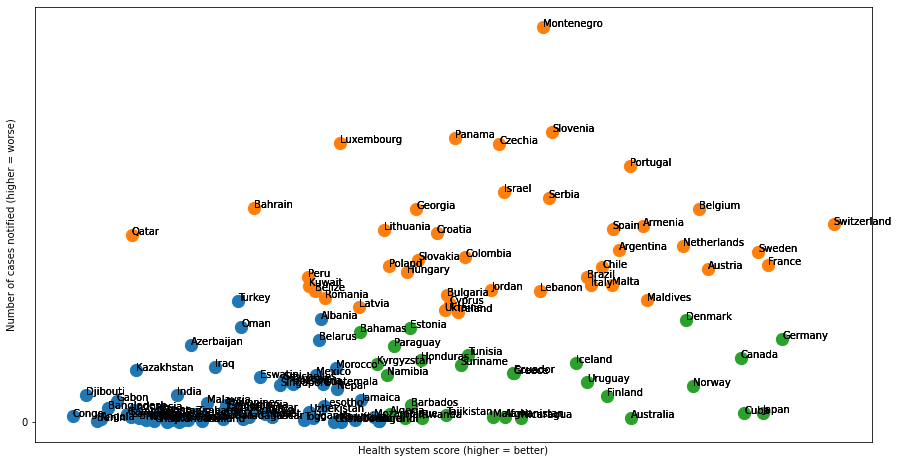

#### DBSCAN_0.01 ####
Clusters: [-1]


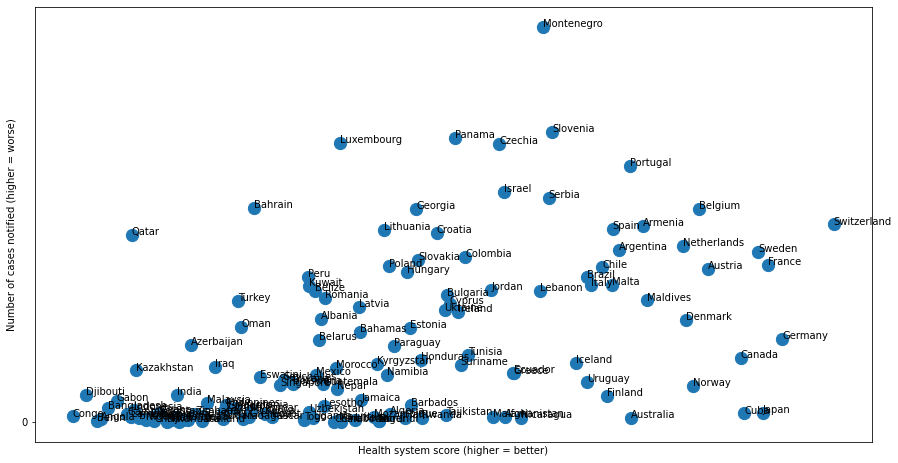

#### DBSCAN_0.2 ####
Clusters: [-1  0]


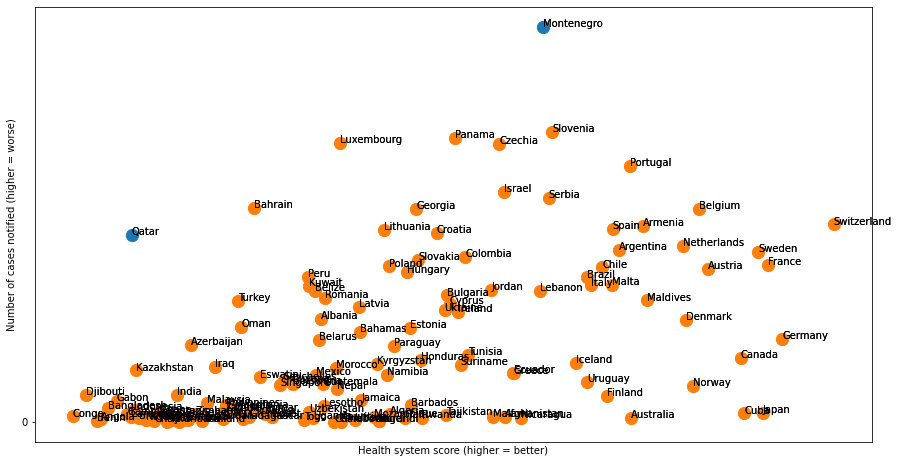

#### Spectral_Clustering_gamma=100 ####
Clusters: [0 1]


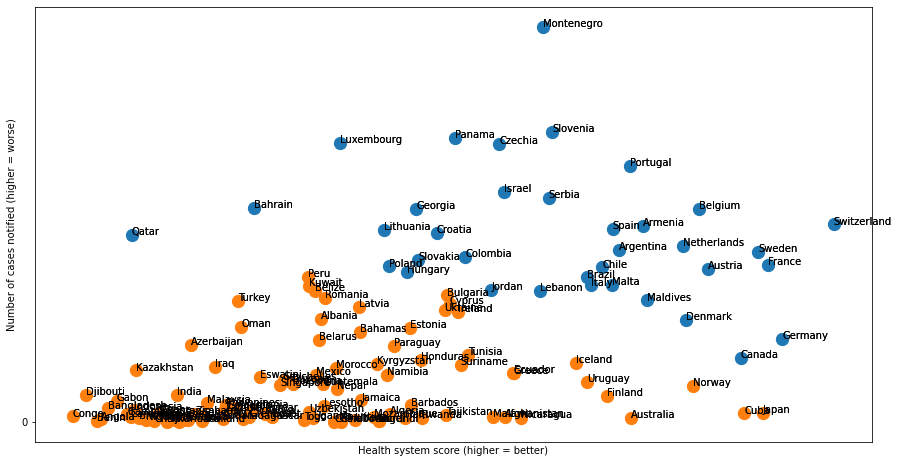

#### Spectral_Clustering_gamma=1 ####
Clusters: [0 1]


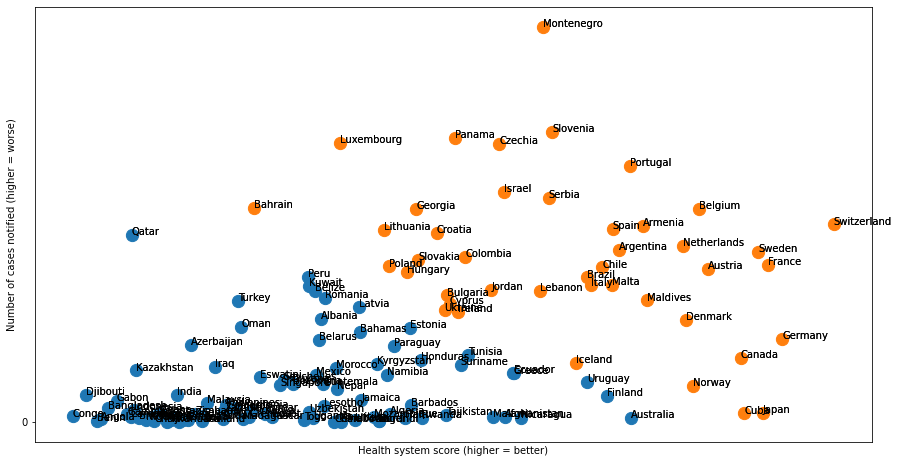

#### GaussianMixture ####
Clusters: [0 1 2]


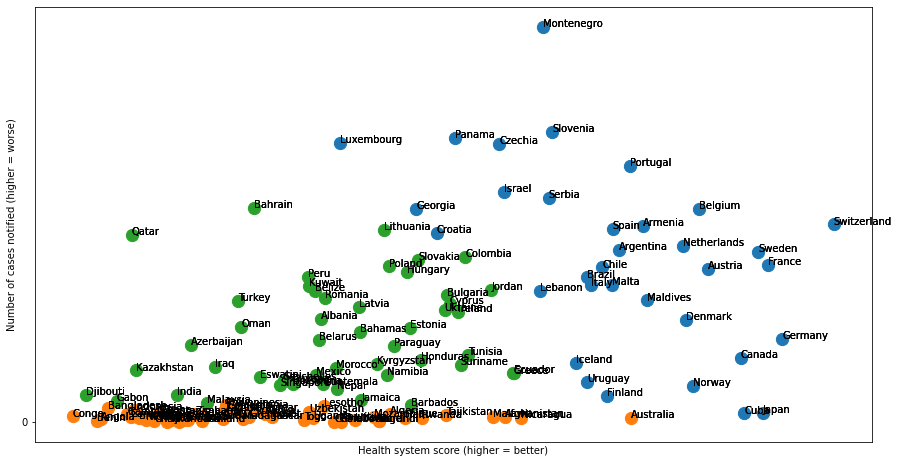

In [19]:
X = np.array(data_test_fact[['health_system_score','cases']])

for name, model in models:
    print("####", name, "####")
    
    yhat = model.fit_predict(X)
    clusters = np.unique(yhat)
    print("Clusters:", clusters)
   
    plt.figure(figsize=(15,8))
    for cluster in clusters:
        row_id = np.where(yhat == cluster)
        
        plt.scatter(X[row_id, 0], X[row_id, 1], s=150)       
        for i, txt in enumerate(paises_test):
            plt.annotate(str(txt), (data_test_fact['health_system_score'].iloc[i],data_test_fact['cases'].iloc[i]))  
    plt.yticks(range(0,1))
    plt.xticks(range(0,1))
    plt.xlabel('Health system score (higher = better)')
    plt.ylabel('Number of cases notified (higher = worse)')
    plt.show()

Como curiosidad observamos que de los modelos DBSCAN con `eps` igual a 0.01 todos los valores son anomalías. Veremos esto más adelante.

De los modelos probados, vamos estudiar más a fondo alguno de ellos para ver qué número de clusters son los ideales para clasificar los datos.

## KMeans

Para buscar el número de grupos óptimo vamos a usar varias técnicas. Primero vamos a usar las puntuaciones de silueta para diferentes números de cluster para el modelo Kmeans.

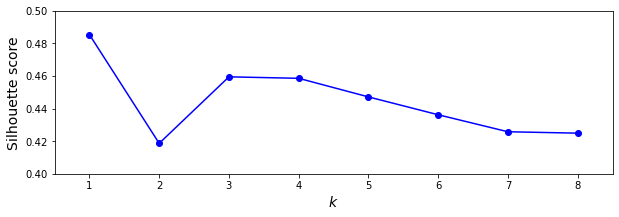

In [20]:
from sklearn.metrics import silhouette_score
model_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]

silhouette_scores = [silhouette_score(X, model.labels_) for model in model_per_k[1:]]

plt.figure(figsize=(10, 3))
plt.plot(range(1,9), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([0.5, 8.5, 0.4, 0.5])   
plt.show()

Según el gráfico de siluetas las mejores opciones son con k=3 y k=4.

Comparémoslo con el método de las inercias.

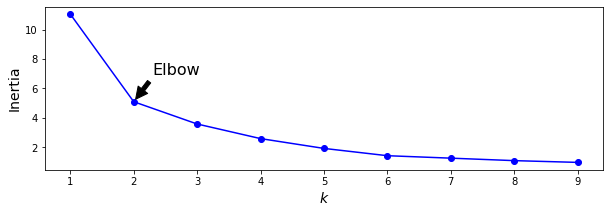

In [21]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(10, 3))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias[1]),
             xytext=(0.25, 0.65),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

Vemos que la inercia desciende drásticamente con k=2 para pasar a reducirse mucho más despacio según incrementamos el valor de k. Si solo conociecemos este índice nos decantaríamos por k=2 pero la inercia no es la mejor técnica para elegir el número k.

Para verlo más claro vamos a trazar un diagrama de siluetas donde visualizaremos la silueta de cada instancia ordenado por el grupo que se asigna y por el valor del coeficiente.

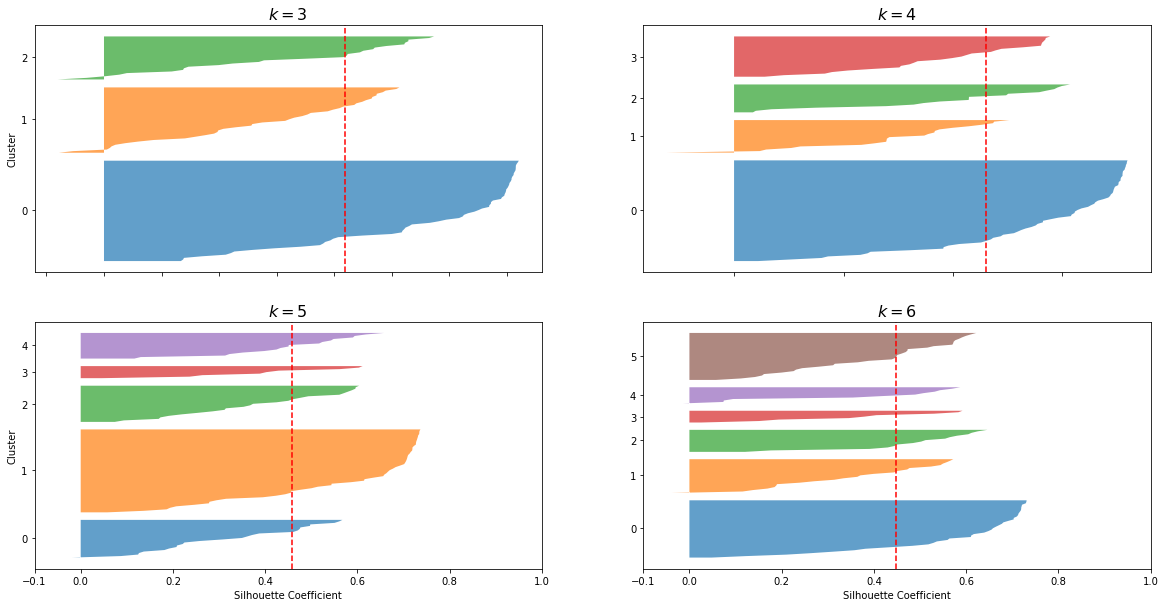

In [22]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(20, 10))

for k in ( 3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

La altura de cada cuchilla indica el número de instancias que contiene y la anchura representa los coeficientes de silueta ordenados de las instancias en el grupo (mientras más ancho mejor).

La línea discontinua indica el coeficiente de silueta medio lo cual quiere decir que las cuchillas que no alcancen esa línea (se queden por debajo) pertenecen a un grupo bastante malo puesto que eso significa que sus instancias están demasiado cerca de otros grupos. Teniendo en cuenta lo dicho y teniendo en cuenta que mientras más parecido sea el tamaño de los grupos mejor podríamos decantarnos finalmente por k=6 a pesar de lo que obtuvimos en las dos técnicas anteriores.

k = 3


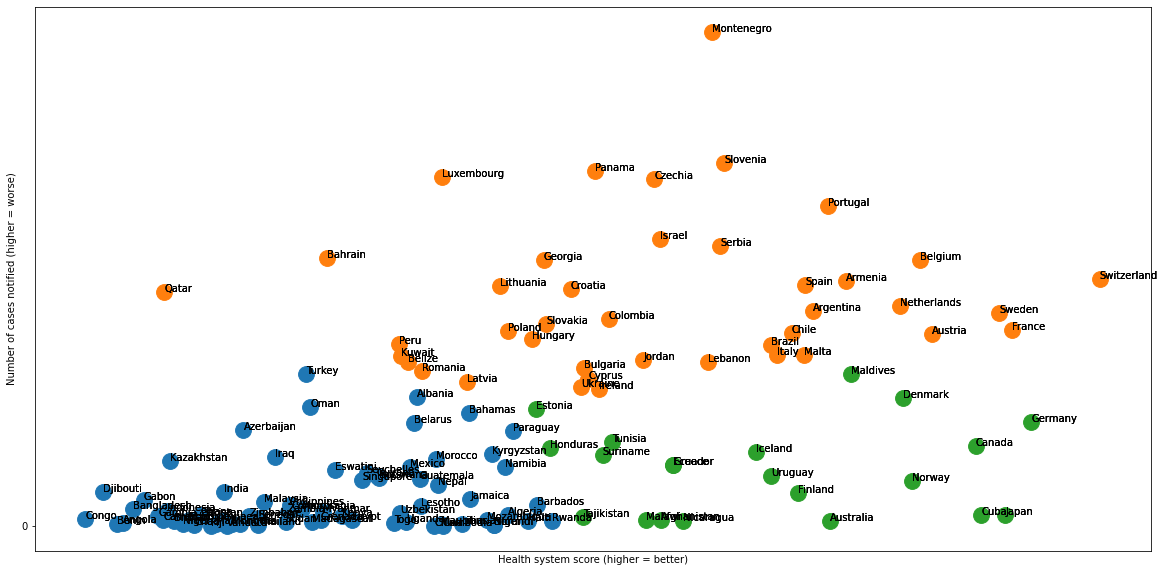

k = 4


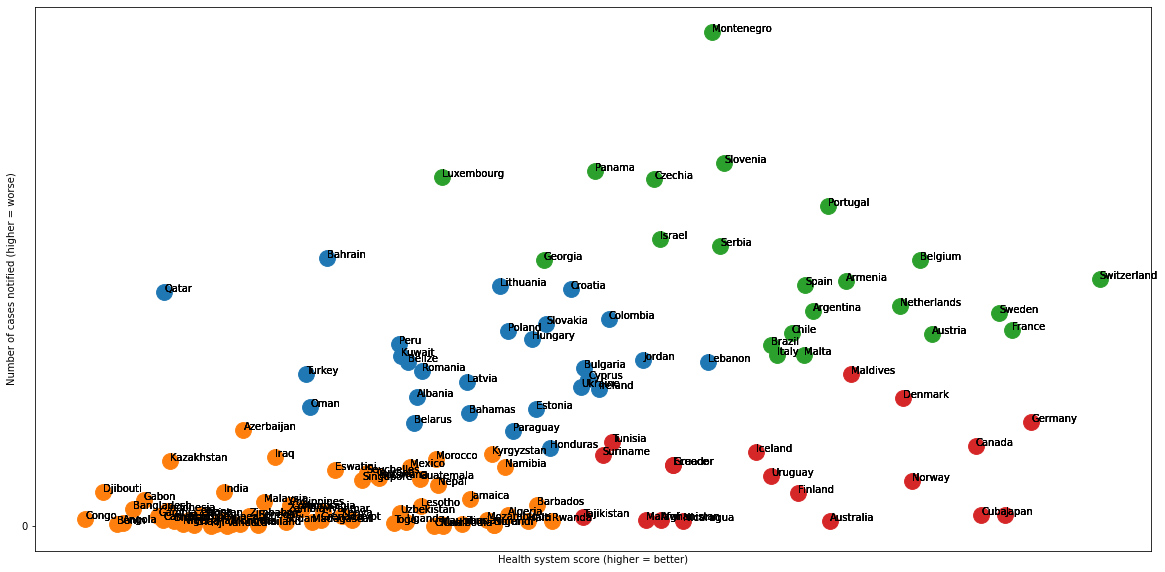

k = 5


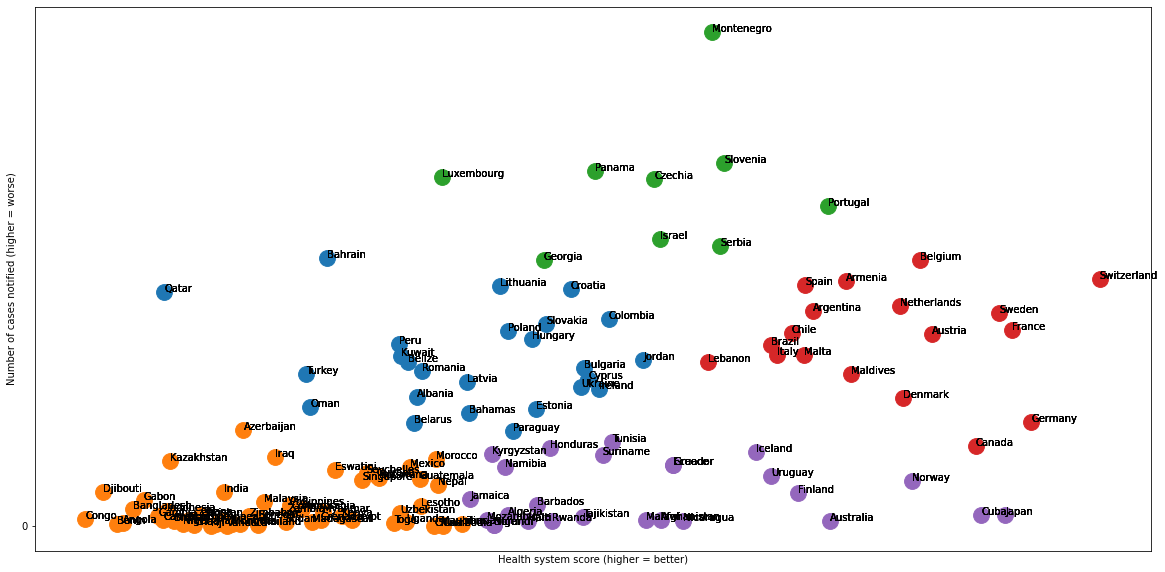

k = 6


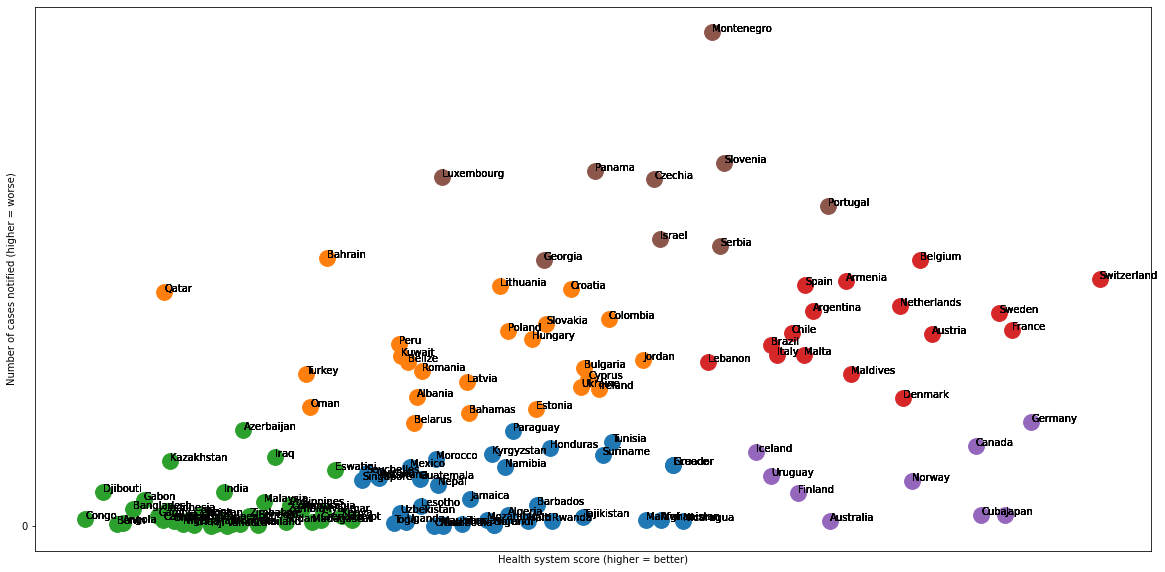

In [23]:
for k in range(3,7):
    print("k =",k)
    model = KMeans(n_clusters = k)

    yhat2 = model.fit_predict(X)
    clusters = np.unique(yhat2)

    plt.figure(figsize=(20,10))


    for cluster in clusters:        
        row_id = np.where(yhat2 == cluster)       
        plt.scatter(X[row_id, 0], X[row_id, 1], s=250)
        for i, txt in enumerate(paises_test):
                plt.annotate(str(txt), (data_test_fact['health_system_score'].iloc[i],data_test_fact['cases'].iloc[i]))                
    # plt.xlim(0,0.5)
    plt.yticks(range(0,1))
    plt.xticks(range(0,1))
    plt.xlabel('Health system score (higher = better)')
    plt.ylabel('Number of cases notified (higher = worse)')
    plt.show()

Parece razonable los 6 grupos teniendo en cuenta la relación entre calidad de sistema de salud frente a número de casos notificados. Podemos observar en rojo que en países con buenos sistemas de salud se han notificado más casos frente a países donde los sistemas de salud son peores han incurrido en menos notificaciones. Esto nos lleva a pensar que la detección de los casos por COVID está relacionada con la calidad del sistema de salud, pues lógicamente, mientras mejor sea este, más controles hay y más casos se detectan.

Sería interesante ver el casos de muertes por países pues deberían haber sido mayores, si no tenemos en cuenta otras variables, en los países con peores sistema de salud.

### DBSCAN

Este algoritmo define grupos como regiones continuas de alta densidad. Definiremos dos parámetros, `eps` cuántas instancias se situarán a esa distancia de cada una de las instancias, y `min_samples` que es el número de instancias que una instancia debe tener dentro de la distancia `eps` para ser considera como una instancia central con lo que todas las instancias dentro de esa distancia perteneceran al mismo grupo que por consiguiente será denso.

In [24]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

Tenemos las etiquetas de todas las instancias en la variable de instancias `labels`. Las instancias con valor -1 el algoritmo las considera como anomalías, es decir, no es instancia central o está a la distancia `eps` de una de ellas.

In [25]:
dbscan.labels_[:10]

array([-1, -1,  0,  0,  1, -1, -1, -1, -1, -1], dtype=int64)

In [26]:
# Número de indices de instancias centrales.
len(dbscan.core_sample_indices_)

59

In [27]:
# Indices instancias centrales.
dbscan.core_sample_indices_[:10]

array([ 2,  3, 11, 12, 16, 17, 18, 21, 22, 23], dtype=int64)

In [28]:
# Instancia centrales.
dbscan.components_[:10]

array([[4.73829966e-01, 2.15666772e-02],
       [1.63560606e-01, 6.69014708e-03],
       [1.71363636e-01, 3.47409083e-02],
       [4.96969697e-01, 4.24885429e-02],
       [1.58873737e-01, 3.55631730e-03],
       [2.04257576e-01, 9.52195536e-03],
       [3.69810606e-01, 9.65992664e-02],
       [4.62575758e-01, 1.47060194e-03],
       [4.21287879e-01, 2.43680994e-04],
       [1.95813973e-01, 1.23044354e-02]])

Número de instancias diferentes. Vemos que obtenemos muchas anomalías (63).

In [29]:
np.unique(dbscan.labels_,return_counts=True)

(array([-1,  0,  1,  2], dtype=int64), array([63, 62,  5,  4], dtype=int64))

Vamos a incremetar el valor de `eps` para ampliar el agrupamiento.

In [30]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

Vamos a realizar un gráfico donde veamos el número de anomalías en función del valor de la distancia máxima entre dos muestras `eps`

In [31]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

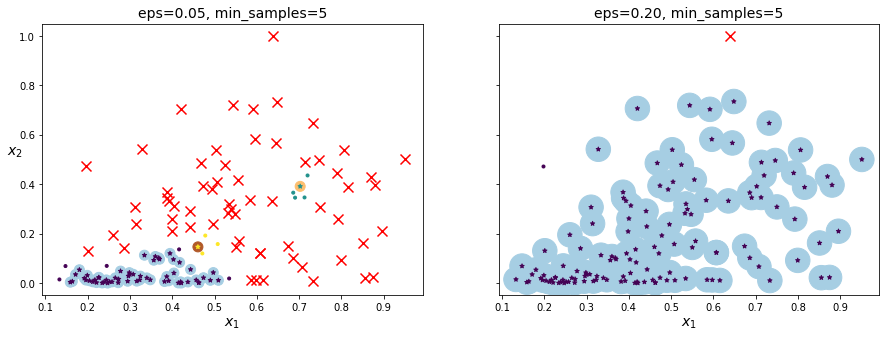

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

Observamos que con eps = 0.05 crea varios grupos de muy pocos elementos e identifica muchas anomalías. Al aumentar el valor de eps hasta 0.2 obtenemos un agrupamiento más compacto y disminuyen drásticamente las anomalías.

### Spectral Clustering


Este algoritmo toma una matriz de similitud entre las instancias y crea un embedding de baja dimensión a partir de ella, es decir, reduce su dimensionalidad para después usar otro algoritmo de agrupamiento en este espacio creado.

In [34]:
from sklearn.cluster import SpectralClustering
sc1 = SpectralClustering(n_clusters=6, gamma=100, random_state=42)
sc1.fit(X)
sc2 = SpectralClustering(n_clusters=6, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=6, random_state=42)

Veamos los agrupamientos y cuantos hay por cada uno de ellos. Viendo los array se puede observar que modificando el valor de `gamma` casi obtenemos valores inversos en todos las etiquetas de ambos modelos. 

In [35]:
sc1.labels_

array([0, 4, 0, 0, 3, 3, 2, 3, 0, 4, 4, 0, 0, 0, 3, 4, 0, 0, 0, 3, 4, 0,
       0, 0, 2, 0, 3, 0, 4, 0, 0, 4, 2, 4, 1, 3, 0, 0, 0, 0, 4, 0, 0, 0,
       2, 3, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 5, 3,
       0, 2, 4, 0, 0, 4, 0, 4, 4, 0, 0, 4, 1, 0, 0, 0, 3, 0, 3, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 4, 0, 1, 0, 4, 0, 4, 5, 4, 4,
       0, 0, 5, 0, 0, 4, 1, 3, 0, 0, 3, 3, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0,
       0, 0])

In [36]:
sc2.labels_

array([3, 4, 3, 0, 1, 1, 5, 1, 4, 4, 4, 0, 3, 4, 1, 4, 0, 0, 3, 1, 4, 3,
       3, 0, 5, 0, 1, 3, 4, 0, 0, 4, 5, 4, 2, 1, 0, 3, 3, 0, 4, 3, 0, 0,
       5, 1, 0, 0, 4, 5, 0, 3, 3, 3, 0, 3, 3, 3, 4, 3, 0, 0, 4, 4, 2, 1,
       3, 5, 4, 0, 3, 4, 3, 4, 1, 3, 3, 4, 2, 3, 3, 0, 1, 0, 1, 0, 3, 3,
       0, 2, 3, 3, 3, 3, 3, 1, 3, 3, 0, 5, 4, 0, 2, 3, 4, 0, 4, 2, 4, 4,
       3, 0, 2, 3, 3, 4, 2, 1, 0, 3, 1, 1, 3, 0, 3, 3, 4, 3, 4, 5, 3, 0,
       0, 0])

Vamos a observarlo gráficamente.

In [37]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

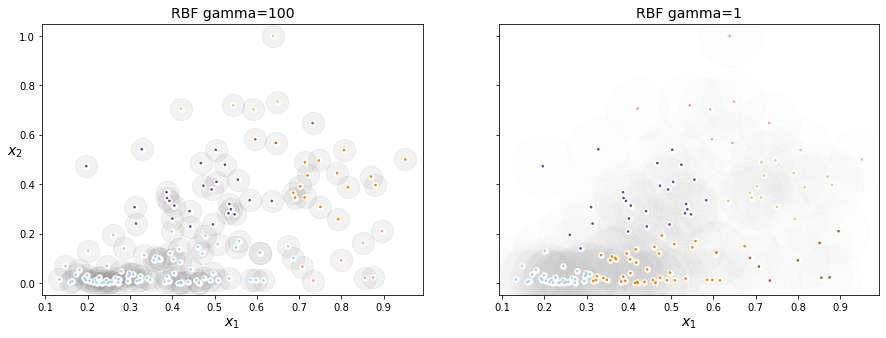

In [38]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

### Gaussian Mixtures

Por definición, un modelo de mezcla gaussiana es un modelo probabilístico que da por supuesto que las instancias se han generado a partir de una mezcla de varias distribuciones  gaussianas cuyos parámetros se desconocen. 

In [78]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, covariance_type='diag', n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

Comprobamos si el algoritmo converge.

In [79]:
gm.converged_

True

Número de iteraciones necesarias para converger.

In [80]:
gm.n_iter_

48

Estimemos la probabilidad de que el modelo asigne cada instancia al grupo más probable.

In [81]:
gm.predict(X)

array([0, 1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 2, 1, 1, 1, 0, 0, 2, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 2, 0, 0,
       1, 1, 2, 0, 1, 1, 0, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 0, 2, 1, 1, 1,
       2, 1, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 0, 0, 2, 1, 0, 1, 2, 0, 2,
       0, 1, 2, 0, 0, 2, 2, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1,
       0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0], dtype=int64)

Al ser un modelo generativo podemos crear nuevas instancias si quisieramos de la siguiente manera. Se ordenan por índice de grupo.

In [82]:
X_new, y_new = gm.sample(6)
X_new

array([[ 0.42335094,  0.02587509],
       [ 0.30328376,  0.00980634],
       [ 0.86593771,  0.4987379 ],
       [ 0.29503213,  0.11299617],
       [ 0.29567214,  0.06489645],
       [ 0.37020956, -0.00415787]])

In [83]:
y_new

array([0, 0, 1, 2, 2, 2])

Podemos estimar la densidad del modelo en cualquier ubicación dada. Lo conseguimos con el método `score_samples()`. Cuanto mayor es la puntuación mayor es la densidad.

In [84]:
gm.score_samples(X)

array([ 1.97550938,  0.10879659,  2.77142939,  2.80539115,  0.46225905,
        0.15241372, -0.0612765 , -0.01967582, -0.532836  ,  0.29265281,
       -0.83841581,  0.57742118,  0.68332868,  0.12538408, -0.40313798,
        0.15532734,  2.5082553 ,  3.27256456,  1.78999758,  0.68121647,
        0.76183859,  2.71623739,  2.79647663,  3.24561189, -0.74572795,
        2.84268773,  0.60594325,  2.87663653,  0.74147889,  1.59108857,
        2.61841144,  0.52833361, -1.64617943,  0.7456164 , -0.81986734,
        0.05577326, -0.02101362,  0.31369173,  3.77409605,  3.3228074 ,
        0.51571925,  1.68278922,  3.39062223,  2.7487357 , -0.41925949,
       -0.58425607,  0.34153082,  2.88761389,  0.2155615 , -0.96109376,
        2.76742158,  0.31352889,  3.7793218 ,  1.69961445,  3.55099267,
        1.76859779,  3.14151164,  0.61257761,  0.64923576,  0.20993266,
        1.2806382 ,  1.3749646 ,  1.08282677,  0.72788973,  0.11610519,
        0.67082629,  1.25768485, -1.84854299,  0.82501537,  0.48

Para calcular el valor de la función de densidad de probabilidades de las instancias dadas calculamos el exponecial de estas puntuaciones. Para estimar la probabilidad de que una instancia quede dentro de una región determinada integramos la función de densidad de probabilidades sobre esa región con lo que debería salir 1.

In [85]:
res = 100
g = np.arange(-10, 10, 1 / res)
equis, ies = np.meshgrid(g, g)

equis_completo = np.vstack([equis.ravel(), ies.ravel()]).T
fun = np.exp(gm.score_samples(equis_completo))

fun_p = fun * (1 / res) ** 2
fun_p.sum()

1.0000000152469168

Vamos a representar los centros de los clusters y las densidades.

In [86]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=5, linewidths=15,
                color=cross_color, zorder=11, alpha=1)

In [87]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

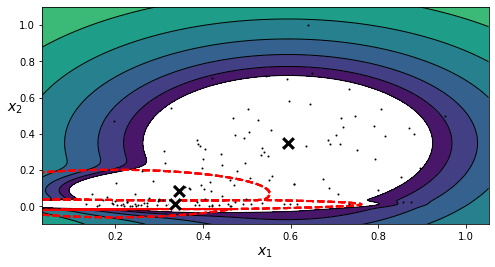

In [88]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

El gráfico muestra las medias de los grupos, las líneas discontinuas nos marcan los límites de decisión (los distintos agrupamientos) y las líneas continuas nos marcan el contorno de densidad del modelo. En la zona blanca la densidad es máxima y a medida que cambia de color hacia afuera la densidad disminuye.

Vamos a detectar anomalías definiendo un umbral del 6% que tras varias pruebas vamos que nos identifica los puntos fuera de los 3 cluster que forman las tres medias. Los valores atípicos vendrán dados por las marcos en rojo dentro de la gráfica.

In [89]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 6)
anomalies = X[densities < density_threshold]

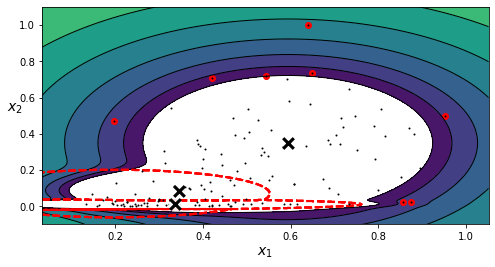

In [90]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='o')
plt.ylim(top=1.1)

plt.show()

Con las mezclas gaussianas no podemos usar como métricas la inercia o la puntuación de la silueta por no ser fiables cuando los grupos no son esféricos o tienen tamaños diferentes. En este caso podemos buscar el modelo que minimice un criterio de información teórico como por ejemplo, el criterio de información bayesiano (BIC) o el criterio de información de Akaike (AIC). Estos penalizan los modelos que tienen más parámetros para aprender y recompensan a los modelos que ajustan bien los datos. Vamos a calcularlos.

In [91]:
bic = gm.bic(X)
aic = gm.aic(X)
bic, aic

(-244.9101518838846, -285.47990908319736)

Vamos a representar ambos criterios con diferentes valores de grupos k. Su valor más bajo para BIC es cuando k = 2 y para AIC es cuando k = 9. 

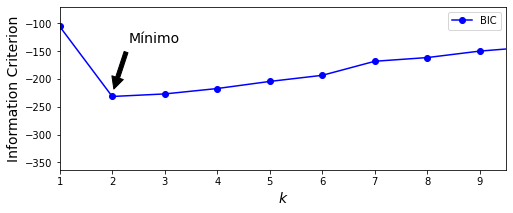

In [96]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X) for k in range(1, 11)]

bics = [model.bic(X) for model in gms_per_k]
# aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
# plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Mínimo',
             xy=(2, bics[2]),
             xytext=(0.25, 0.8),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
# plt.annotate('Mínimo',
#              xy=(9, aics[3]),
#              xytext=(0.8, 0.6),
#              textcoords='figure fraction',
#              fontsize=14,
#              arrowprops=dict(facecolor='black', shrink=0.1)
#             )
plt.legend()

plt.show()

Busquemos la mejor combinación de valores tanto para el número de clústeres como para el hiperparámetro `covariance_type`:

In [93]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [94]:
best_k

3

In [95]:
best_covariance_type

'diag'

Lo que nos indica que para este modelo el mejor número de clusters es k = 3.

### Otros modelos

Para el estudio de los datos con otros modelos vamos a añadir otro dataset con lo que comenzaremos a carga desde el principio todos los datos de todos los dataset.

In [131]:
## URL de los dataset a utilizar
# Dataset principal
url_base_dataset = 'https://raw.githubusercontent.com/samuelojeda082/tecnicasia/main/dataset.csv'

# Datasets complementarios
url_aditional_data1 = 'https://raw.githubusercontent.com/samuelojeda082/tecnicasia/main/data_merged.csv'
url_aditional_data2 = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv'

In [132]:
# Cargar fichero con los datos de los casos de covid
r = requests.get(url_base_dataset)
if r.ok:
    data = r.content.decode('utf8')
    df_main_data = pd.read_csv(io.StringIO(data), index_col=0, parse_dates=[0], infer_datetime_format=True, sep=',').reset_index()
else:
    print(r)

In [133]:
# ELiminamos datos Na
df_main_data = df_main_data.dropna()

In [134]:
df_main_data.head()

,dateRep,year_week,cases_weekly,deaths_weekly,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,notification_rate_per_100000_population_14_days
0,2021-01-02,2021-04,267,16,Afghanistan,AF,AFG,38041757.0,Asia,2.58
1,2021-01-25,2021-03,713,43,Afghanistan,AF,AFG,38041757.0,Asia,3.34
2,2021-01-18,2021-02,557,45,Afghanistan,AF,AFG,38041757.0,Asia,3.24
3,2021-11-01,2021-01,675,71,Afghanistan,AF,AFG,38041757.0,Asia,4.15
4,2021-04-01,2020-53,902,60,Afghanistan,AF,AFG,38041757.0,Asia,7.61


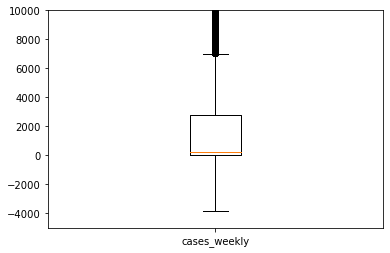

In [135]:
# Describimos el dataset mediante gráficos
plt.boxplot(df_main_data["cases_weekly"])
atributos = ["cases_weekly"]
plt.xticks(range(1,2),atributos)
plt.ylim(-5000,10000)
plt.show()

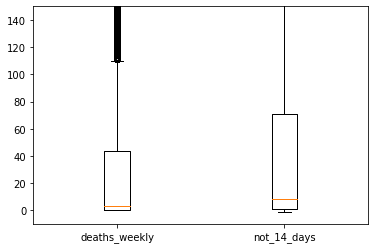

In [136]:
# Describimos el dataset mediante gráficos
plt.boxplot([df_main_data["deaths_weekly"],df_main_data["notification_rate_per_100000_population_14_days"]])
atributos = ["deaths_weekly","not_14_days"]
plt.xticks(range(1,3),atributos)
plt.xticks()
plt.ylim(-10,150)
plt.show()

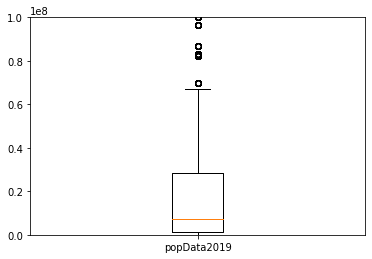

In [137]:
# Describimos el dataset mediante gráficos
plt.boxplot([df_main_data["popData2019"]])
atributos = ["popData2019"]
plt.xticks(range(1,2),atributos)
plt.xticks()
plt.ylim(-10,100000000)
plt.show()

In [138]:
# Normalizo los datos del dataset principal
paises = df_main_data['countriesAndTerritories']
date = df_main_data['dateRep']
df_main_data = df_main_data.iloc[:,[2,3,7,9]]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df_main_data)
scaled_df = pd.DataFrame(scaled_df, columns=['cases_weekly', 'deaths_weekly', 'popData2019', 'notif_rate_per_100000_pop_14-days'])
scaled_df.head()

,cases_weekly,deaths_weekly,popData2019,notif_rate_per_100000_pop_14-days
0,0.002312,0.036527,0.026532,0.030201
1,0.002562,0.037634,0.026532,0.030371
2,0.002474,0.037716,0.026532,0.030348
3,0.002541,0.038782,0.026532,0.030552
4,0.002668,0.038331,0.026532,0.031325


In [139]:
# Inserto en el dataset escalado una columna de países y otra de fechas
scaled_df.insert(0,"Countries",paises, True)
scaled_df.insert(1,"Date",date, True)
scaled_df.head()

,Countries,Date,cases_weekly,deaths_weekly,popData2019,notif_rate_per_100000_pop_14-days
0,Afghanistan,2021-01-02,0.002312,0.036527,0.026532,0.030201
1,Afghanistan,2021-01-25,0.002562,0.037634,0.026532,0.030371
2,Afghanistan,2021-01-18,0.002474,0.037716,0.026532,0.030348
3,Afghanistan,2021-11-01,0.002541,0.038782,0.026532,0.030552
4,Afghanistan,2021-04-01,0.002668,0.038331,0.026532,0.031325


In [140]:
# Cargar el primer fichero con datos de datasets adicionales
r = requests.get(url_aditional_data1)
if r.ok:
    data = r.content.decode('utf8')
    df_additional_data1 = pd.read_csv(io.StringIO(data), index_col=0, parse_dates=[0], sep=';').reset_index()
else:
    print(r)

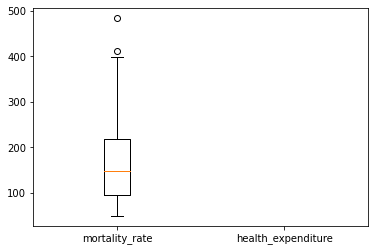

In [141]:
# Describimos el dataset mediante gráficos
plt.boxplot([df_additional_data1.iloc[:,1],df_additional_data1.iloc[:,2]])
atributos = ["mortality_rate", "health_expenditure"]
plt.xticks(range(1,3),atributos)
plt.xticks()
plt.show()

In [142]:
# Unimos con los datasets adicionales
df_merge = pd.merge(scaled_df, df_additional_data1, left_on='Countries', right_on='country', how='outer')

In [143]:
# Borramos los datos que no se han unido correctamente porque faltan en el dataset adicional
mask = (df_merge['Countries'].isna()) | (df_merge['country'].isna())
df_clean = df_merge[~mask].copy()
df_format = df_clean.copy()

In [144]:
# Calcular y escalar el índice del sistema de salud
max_health_exp = df_format['health_expenditure'].max()
df_format['health_system_score'] = (1 - df_format['health_expenditure']/1000) * df_format['health_expenditure']/max_health_exp

max_mort = df_format['mortality_rate'].max()
df_format['mortality_rate'] = (1 - df_format['mortality_rate']/1000) * df_format['mortality_rate']/max_mort

# Dar formato al dataframe y limpiar
df_format = df_format[~df_format['health_system_score'].isna()]
df_format = df_format[~df_format['mortality_rate'].isna()]
df_format = df_format.drop(['country'], axis=1)

In [145]:
# Segundo dataset adicional
r = requests.get(url_aditional_data2)
if r.ok:
    data = r.content.decode('utf8')
    df_aditional_data2 = pd.read_csv(io.StringIO(data), index_col=0, parse_dates=[0], sep=',').reset_index()
else:
    print(r)

In [146]:
# Sustituimos los NA por 0
df_aditional_data2 = df_aditional_data2.fillna(0)

In [147]:
df_aditional_data2.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
0,Albania,ALB,2021-01-10,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1,Albania,ALB,2021-01-11,0.0,0.0,0.0,0.0,64.0,0.00,0.00,0.0,22.0
2,Albania,ALB,2021-01-12,128.0,128.0,0.0,0.0,64.0,0.00,0.00,0.0,22.0
3,Albania,ALB,2021-01-13,188.0,188.0,0.0,60.0,63.0,0.01,0.01,0.0,22.0
4,Albania,ALB,2021-01-14,266.0,266.0,0.0,78.0,66.0,0.01,0.01,0.0,23.0


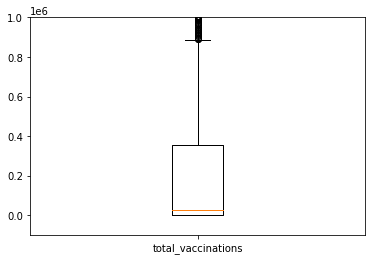

In [159]:
# Describimos el dataset mediante gráficos
plt.boxplot([df_aditional_data2.iloc[:,3]])
atributos = ["total_vaccinations"]
plt.xticks(range(1,2),atributos)
plt.xticks()
plt.ylim(-100000,1000000)
plt.show()

In [160]:
# Normalizo los datos del dataset
paises2 = df_aditional_data2['location']
date2 = df_aditional_data2['date']
df_aditional_data2 = df_aditional_data2.iloc[:,[11]]
scaler2 = MinMaxScaler()
scaled_df2 = scaler2.fit_transform(df_aditional_data2)
scaled_df2 = pd.DataFrame(scaled_df2, columns = ['total_vaccinations'])

In [161]:
# Inserto en el dataset una columna con el nombre de los países y otra de fechas 
scaled_df2.insert(0,"location",paises2, True)
scaled_df2.insert(1,"date",date2, True)

In [162]:
# Cambio el formato de las columnas fecha para poder hacer la unión por ese campo
df_format['Date'] = df_format['Date'].astype(str)
scaled_df2['date'] = scaled_df2['date'].astype(str)

In [163]:
# Unimos con los datasets adicionales
df_merge2 = pd.merge(df_format, scaled_df2, left_on = ['Countries','Date'], right_on = ['location','date'], how='outer')

In [164]:
# Borramos los datos que no se han unido correctamente porque faltan en el dataset adicional
mask2 = (df_merge2['Countries'].isna()) | (df_merge2['location'].isna())
df_clean2 = df_merge2[~mask2].copy()

In [165]:
# Dataset definitivo que usaremos para la regresión
df = df_clean2.copy()

In [166]:
df.head()

,Countries,Date,cases_weekly,deaths_weekly,popData2019,notif_rate_per_100000_pop_14-days,mortality_rate,health_expenditure,health_system_score,location,date,total_vaccinations
57,Albania,2021-01-25,0.004455,0.037347,0.001996,0.094032,0.179677,5.26,0.440432,Albania,2021-01-25,0.000162
58,Albania,2021-01-18,0.004489,0.037839,0.001996,0.084438,0.179677,5.26,0.440432,Albania,2021-01-18,0.000616
204,Argentina,2021-01-02,0.021790,0.076702,0.031232,0.069220,0.204304,9.62,0.801974,Argentina,2021-01-02,0.006285
205,Argentina,2021-01-25,0.026957,0.089042,0.031232,0.075893,0.204304,9.62,0.801974,Argentina,2021-01-25,0.006479
206,Argentina,2021-01-18,0.029277,0.096175,0.031232,0.083665,0.204304,9.62,0.801974,Argentina,2021-01-18,0.008811


In [167]:
## Primer modelo, un random forest regressor mediante scikit learn
# Dividimos los datos entre datos de entrenamiento y de test, en un 80%-20%
X = df.iloc[:,[2,4,5,6,8,11]].values
y = df.iloc[:, 3].values

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size = 0.2, random_state = 1, shuffle = True)

In [168]:
# Creamos el modelo
modelo1 = RandomForestRegressor(n_estimators = 100, criterion = "mae", max_depth = 10)
modelo1.fit(X_train, Y_train)

RandomForestRegressor(criterion='mae', max_depth=10)

In [169]:
# Hacemos las predicciones
predictions1 = modelo1.predict(X_validation)

In [170]:
# Sacamos métricas
print('Mean Squared Error:', metrics.mean_squared_error(Y_validation, predictions1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_validation, predictions1)))
print("Coeficiente de determinación: ", r2_score(Y_validation, predictions1))

Mean Squared Error: 0.0004497621249731271
Root Mean Squared Error: 0.021207595926297895
Coeficiente de determinación:  0.8404944487386891


In [171]:
# Creamos el segundo modelo
modelo2 = LinearRegression()
modelo2.fit(X_train, Y_train)

LinearRegression()

In [172]:
# Hacemos las predicciones
predictions2 = modelo2.predict(X_validation)

In [173]:
# Sacamos métricas
print('Mean Squared Error:', metrics.mean_squared_error(Y_validation, predictions2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_validation, predictions2)))
print("Coeficiente de determinación: ", r2_score(Y_validation, predictions2))
print("Coeficientes: \n", modelo2.coef_)

Mean Squared Error: 0.0003803874958136461
Root Mean Squared Error: 0.019503525215038592
Coeficiente de determinación:  0.8650977620307836
Coeficientes: 
 [ 1.57716831 -0.00302093 -0.11020394  0.03574576  0.01077366 -0.00368288]
